# Interactive Demos: CFG Visualization and Denotational Semantics

This page demonstrates interactive visualizations and widgets that help understand context-free grammars, syntax trees, and denotational semantics. Use the widgets below to explore different concepts interactively!

## Table of Contents
1. [CFG Visualization](#cfg-viz)
2. [Interactive Syntax Tree Builder](#syntax-tree)
3. [Denotational Semantics Calculator](#denotational-calc)
4. [Grammar Rule Explorer](#grammar-explorer)


In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import json
from collections import defaultdict
import re

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.style.use('default')


## 1. CFG Visualization {#cfg-viz}

Context-Free Grammars can be visualized as directed graphs where nodes represent non-terminals and edges represent production rules. Use the interactive widget below to explore different grammars!


Dropdown(description='Grammar:', index=2, options=('Arithmetic Expressions', 'Simple Language', 'Balanced Pare…

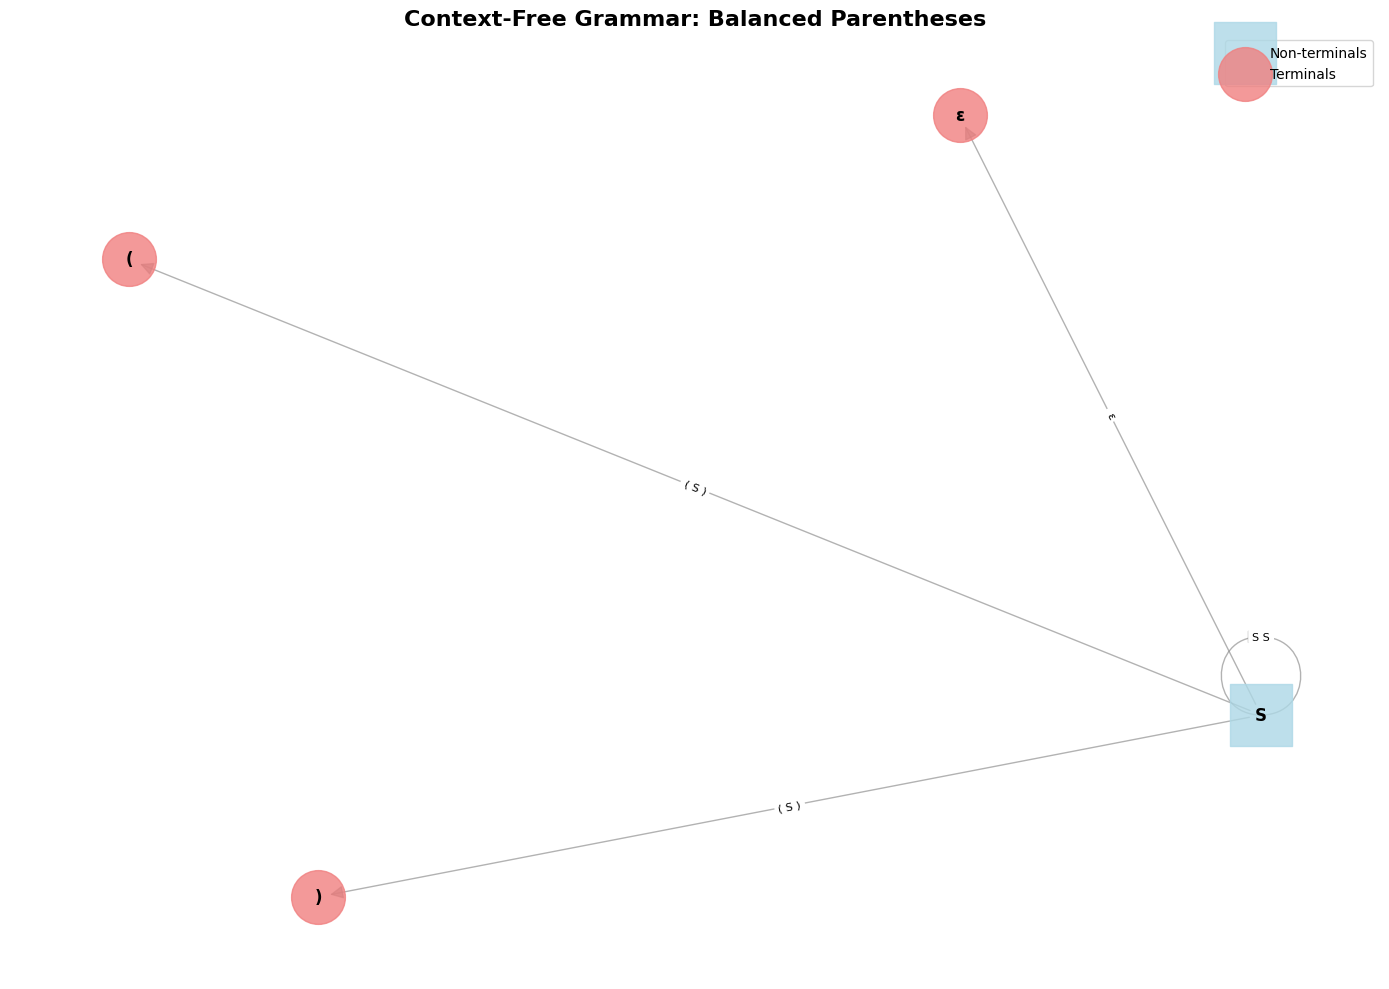

In [3]:
class CFGVisualizer:
    def __init__(self):
        self.grammars = {
            'Arithmetic Expressions': {
                'E': ['E + T', 'E - T', 'T'],
                'T': ['T * F', 'T / F', 'F'],
                'F': ['( E )', 'id', 'num']
            },
            'Simple Language': {
                'S': ['A B', 'C'],
                'A': ['a A', 'a'],
                'B': ['b B', 'b'],
                'C': ['c C', 'c']
            },
            'Balanced Parentheses': {
                'S': ['( S )', 'S S', '']
            },
            'If-Then-Else': {
                'S': ['if E then S', 'if E then S else S', 'id = E', 'print E'],
                'E': ['E + E', 'E * E', 'id', 'num', 'E < E', 'E = E']
            }
        }
    
    def create_cfg_graph(self, grammar_name):
        grammar = self.grammars[grammar_name]
        G = nx.DiGraph()
        
        # Add nodes and edges
        for non_terminal, productions in grammar.items():
            G.add_node(non_terminal, node_type='non_terminal')
            
            for production in productions:
                if production == '':  # epsilon production
                    G.add_node('ε', node_type='terminal')
                    G.add_edge(non_terminal, 'ε', label='ε')
                else:
                    # Parse production to find non-terminals
                    symbols = production.split()
                    for symbol in symbols:
                        if symbol in grammar:  # It's a non-terminal
                            G.add_edge(non_terminal, symbol, label=production)
                        else:  # It's a terminal
                            G.add_node(symbol, node_type='terminal')
                            G.add_edge(non_terminal, symbol, label=production)
        
        return G
    
    def visualize_cfg(self, grammar_name):
        G = self.create_cfg_graph(grammar_name)
        
        plt.figure(figsize=(14, 10))
        
        # Use spring layout for better positioning
        pos = nx.spring_layout(G, k=3, iterations=50)
        
        # Separate nodes by type
        non_terminals = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'non_terminal']
        terminals = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'terminal']
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, nodelist=non_terminals, 
                             node_color='lightblue', node_size=2000, 
                             node_shape='s', alpha=0.8)
        nx.draw_networkx_nodes(G, pos, nodelist=terminals, 
                             node_color='lightcoral', node_size=1500, 
                             node_shape='o', alpha=0.8)
        
        # Draw edges with labels
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                              arrowsize=20, alpha=0.6)
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
        
        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
        
        plt.title(f'Context-Free Grammar: {grammar_name}', fontsize=16, fontweight='bold')
        plt.legend(['Non-terminals', 'Terminals'], loc='upper right')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print grammar rules
        print(f"\nGrammar Rules for '{grammar_name}':")
        print("=" * 50)
        for non_terminal, productions in self.grammars[grammar_name].items():
            for production in productions:
                if production == '':
                    print(f"{non_terminal} → ε")
                else:
                    print(f"{non_terminal} → {production}")
        print()

# Create the visualizer
cfg_viz = CFGVisualizer()

# Create interactive widget
grammar_selector = widgets.Dropdown(
    options=list(cfg_viz.grammars.keys()),
    value='Arithmetic Expressions',
    description='Grammar:',
    style={'description_width': 'initial'}
)

def on_grammar_change(change):
    clear_output(wait=True)
    display(grammar_selector)
    cfg_viz.visualize_cfg(change['new'])

grammar_selector.observe(on_grammar_change, names='value')
display(grammar_selector)
cfg_viz.visualize_cfg('Arithmetic Expressions')


## 2. Interactive Syntax Tree Builder {#syntax-tree}

Build and visualize syntax trees interactively! This demonstrates how programs are represented as trees in denotational semantics.


Text(value='2 + 3 * 4', description='Expression:', placeholder='Enter expression (e.g., 2 + 3 * 4)', style=Tex…

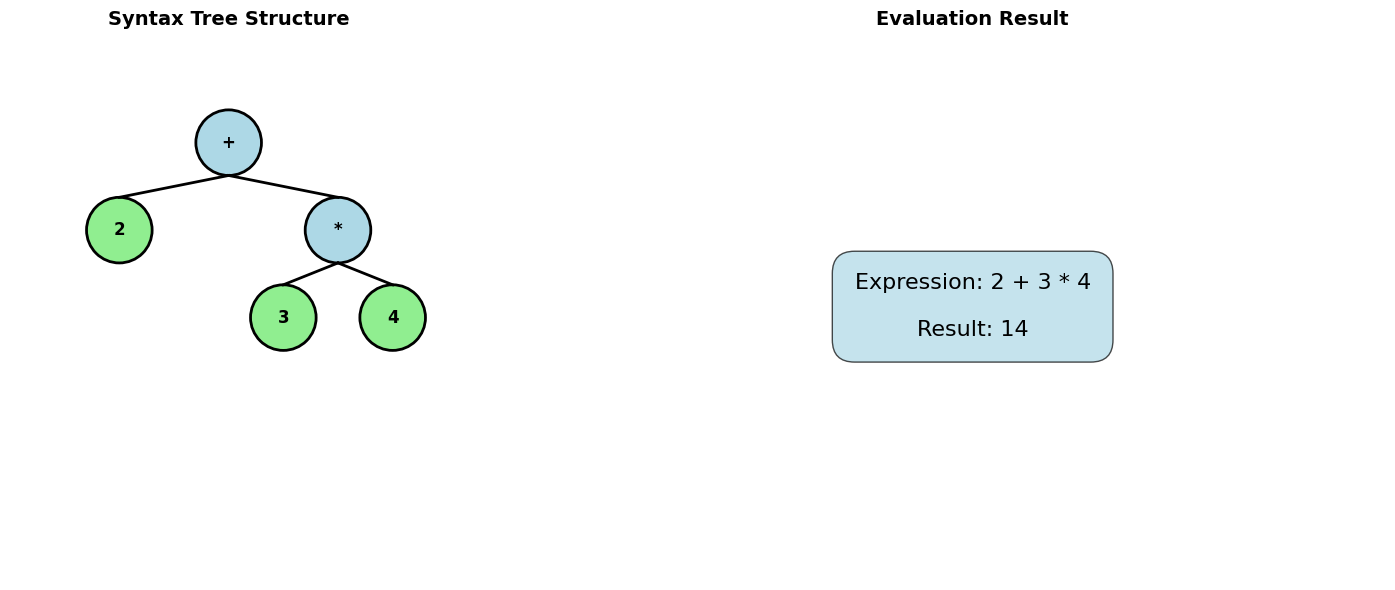


Tree Structure for '2 + 3 * 4':
{
  "type": "BinaryOp",
  "op": "+",
  "left": {
    "type": "Number",
    "value": 2
  },
  "right": {
    "type": "BinaryOp",
    "op": "*",
    "left": {
      "type": "Number",
      "value": 3
    },
    "right": {
      "type": "Number",
      "value": 4
    }
  }
}


In [6]:
class SyntaxTreeBuilder:
    def __init__(self):
        self.tree_data = {}
    
    def parse_expression(self, expr):
        """Simple recursive descent parser for arithmetic expressions"""
        expr = expr.replace(' ', '')
        
        # Handle parentheses
        if expr.startswith('(') and expr.endswith(')'):
            return self.parse_expression(expr[1:-1])
        
        # Find the rightmost + or - (lowest precedence)
        paren_count = 0
        for i in range(len(expr) - 1, -1, -1):
            if expr[i] == ')':
                paren_count += 1
            elif expr[i] == '(':
                paren_count -= 1
            elif paren_count == 0 and expr[i] in '+-':
                return {
                    'type': 'BinaryOp',
                    'op': expr[i],
                    'left': self.parse_expression(expr[:i]),
                    'right': self.parse_expression(expr[i+1:])
                }
        
        # Find the rightmost * or / (higher precedence)
        paren_count = 0
        for i in range(len(expr) - 1, -1, -1):
            if expr[i] == ')':
                paren_count += 1
            elif expr[i] == '(':
                paren_count -= 1
            elif paren_count == 0 and expr[i] in '*/':
                return {
                    'type': 'BinaryOp',
                    'op': expr[i],
                    'left': self.parse_expression(expr[:i]),
                    'right': self.parse_expression(expr[i+1:])
                }
        
        # If it's just a number or variable
        if expr.isdigit() or (expr[0] == '-' and expr[1:].isdigit()):
            return {'type': 'Number', 'value': int(expr)}
        else:
            return {'type': 'Variable', 'name': expr}
    
    def visualize_tree(self, tree, ax=None, x=0, y=0, width=1, level=0):
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))
        
        # Draw current node
        if tree['type'] == 'BinaryOp':
            node_text = tree['op']
            color = 'lightblue'
        elif tree['type'] == 'Number':
            node_text = str(tree['value'])
            color = 'lightgreen'
        else:  # Variable
            node_text = tree['name']
            color = 'lightcoral'
        
        # Draw node
        circle = plt.Circle((x, y), 0.15, color=color, ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, node_text, ha='center', va='center', fontsize=12, fontweight='bold')
        
        # Draw children
        if tree['type'] == 'BinaryOp':
            left_x = x - width/2
            right_x = x + width/2
            child_y = y - 0.4
            
            # Draw edges
            ax.plot([x, left_x], [y-0.15, child_y+0.15], 'k-', linewidth=2)
            ax.plot([x, right_x], [y-0.15, child_y+0.15], 'k-', linewidth=2)
            
            # Recursively draw children
            self.visualize_tree(tree['left'], ax, left_x, child_y, width/2, level+1)
            self.visualize_tree(tree['right'], ax, right_x, child_y, width/2, level+1)
    
    def evaluate_tree(self, tree, variables=None):
        if variables is None:
            variables = {}
        
        if tree['type'] == 'Number':
            return tree['value']
        elif tree['type'] == 'Variable':
            return variables.get(tree['name'], 0)
        elif tree['type'] == 'BinaryOp':
            left_val = self.evaluate_tree(tree['left'], variables)
            right_val = self.evaluate_tree(tree['right'], variables)
            
            if tree['op'] == '+':
                return left_val + right_val
            elif tree['op'] == '-':
                return left_val - right_val
            elif tree['op'] == '*':
                return left_val * right_val
            elif tree['op'] == '/':
                return left_val / right_val if right_val != 0 else float('inf')
        
        return 0

# Create the tree builder
tree_builder = SyntaxTreeBuilder()

# Create interactive widgets
expression_input = widgets.Text(
    value='2 + 3 * 4',
    placeholder='Enter expression (e.g., 2 + 3 * 4)',
    description='Expression:',
    style={'description_width': 'initial'}
)

def build_and_visualize_tree(expr):
    try:
        tree = tree_builder.parse_expression(expr)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Visualize tree
        tree_builder.visualize_tree(tree, ax1)
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-2, 0.5)
        ax1.set_aspect('equal')
        ax1.set_title('Syntax Tree Structure', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Show evaluation
        result = tree_builder.evaluate_tree(tree)
        ax2.text(0.5, 0.5, f'Expression: {expr}\n\nResult: {result}', 
                ha='center', va='center', fontsize=16, 
                bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.7))
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title('Evaluation Result', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print tree structure
        print(f"\nTree Structure for '{expr}':")
        print("=" * 40)
        print(json.dumps(tree, indent=2))
        
    except Exception as e:
        print(f"Error parsing expression: {e}")
        print("Please use valid arithmetic expressions with +, -, *, /, parentheses, and numbers.")

def on_expression_submit(change):
    clear_output(wait=True)
    display(expression_input)
    build_and_visualize_tree(change['new'])

expression_input.observe(on_expression_submit, names='value')
display(expression_input)
build_and_visualize_tree('2 + 3 * 4')


## 3. Denotational Semantics Calculator {#denotational-calc}

This interactive calculator demonstrates how denotational semantics assigns mathematical meanings to program constructs. Explore how different language constructs map to mathematical functions!


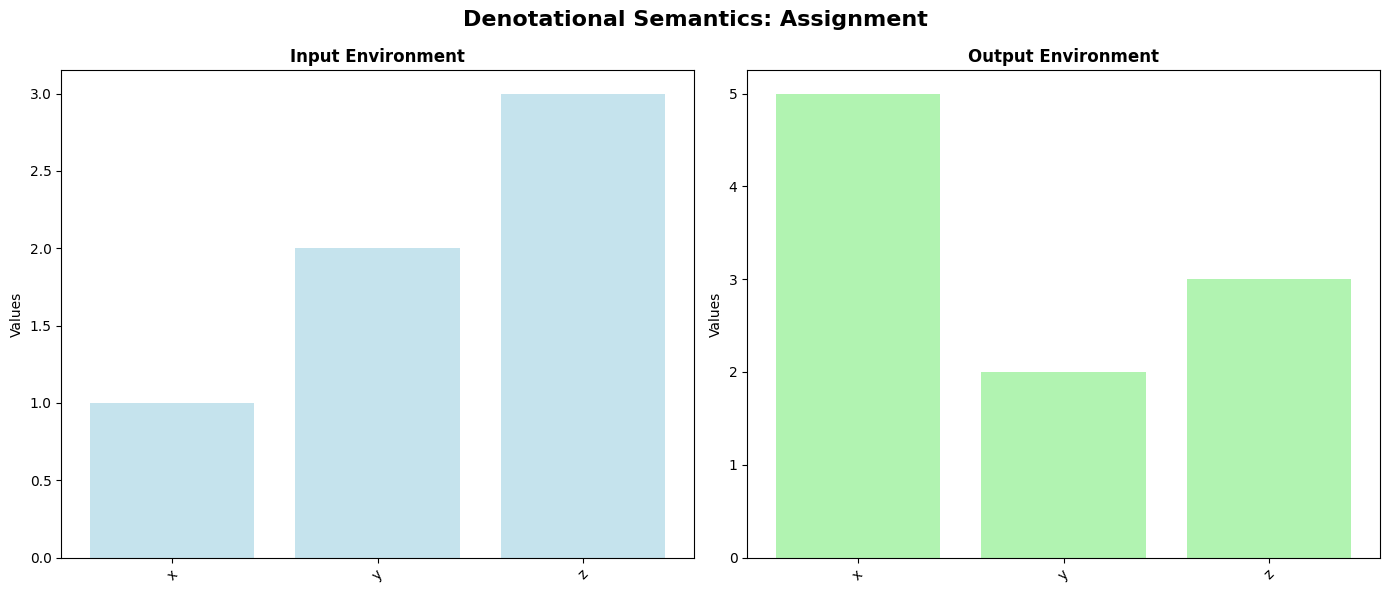


Semantic Function: assignment
Parameters: ('x', 5)
Result: {'x': 5, 'y': 2, 'z': 3}


In [5]:
class DenotationalSemantics:
    def __init__(self):
        self.environment = {}
    
    def semantic_function(self, construct_type, params):
        """Define semantic functions for different language constructs"""
        if construct_type == 'assignment':
            var, expr_val = params
            return lambda env: {**env, var: expr_val}
        
        elif construct_type == 'arithmetic':
            op, left_val, right_val = params
            if op == '+':
                return lambda env: left_val + right_val
            elif op == '-':
                return lambda env: left_val - right_val
            elif op == '*':
                return lambda env: left_val * right_val
            elif op == '/':
                return lambda env: left_val / right_val if right_val != 0 else float('inf')
        
        elif construct_type == 'conditional':
            condition, then_val, else_val = params
            return lambda env: then_val if condition else else_val
        
        elif construct_type == 'sequence':
            stmt1, stmt2 = params
            return lambda env: stmt2(stmt1(env))
    
    def visualize_semantic_function(self, func, env, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Show input environment
        ax1.bar(env.keys(), env.values(), color='lightblue', alpha=0.7)
        ax1.set_title('Input Environment', fontweight='bold')
        ax1.set_ylabel('Values')
        ax1.tick_params(axis='x', rotation=45)
        
        # Apply semantic function and show result
        result = func(env)
        if isinstance(result, dict):  # Environment update
            ax2.bar(result.keys(), result.values(), color='lightgreen', alpha=0.7)
            ax2.set_title('Output Environment', fontweight='bold')
            ax2.set_ylabel('Values')
            ax2.tick_params(axis='x', rotation=45)
        else:  # Value result
            ax2.bar(['Result'], [result], color='lightcoral', alpha=0.7)
            ax2.set_title('Computed Value', fontweight='bold')
            ax2.set_ylabel('Value')
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return result

# Create semantic calculator
sem_calc = DenotationalSemantics()

# Create interactive widgets
construct_type = widgets.Dropdown(
    options=['assignment', 'arithmetic', 'conditional'],
    value='assignment',
    description='Construct:',
    style={'description_width': 'initial'}
)

def demonstrate_semantics(construct_type, *params):
    clear_output(wait=True)
    
    # Create semantic function
    semantic_func = sem_calc.semantic_function(construct_type, params)
    
    # Create sample environment
    sample_env = {'x': 1, 'y': 2, 'z': 3}
    
    # Visualize
    result = sem_calc.visualize_semantic_function(
        semantic_func, sample_env, 
        f'Denotational Semantics: {construct_type.title()}'
    )
    
    print(f"\nSemantic Function: {construct_type}")
    print(f"Parameters: {params}")
    print(f"Result: {result}")

# Initial display
display(construct_type)

def on_construct_change(change):
    clear_output(wait=True)
    display(construct_type)
    
    # Demonstrate with current values
    if change['new'] == 'assignment':
        demonstrate_semantics('assignment', 'x', 5)
    elif change['new'] == 'arithmetic':
        demonstrate_semantics('arithmetic', '+', 3, 4)
    elif change['new'] == 'conditional':
        demonstrate_semantics('conditional', True, 10, 20)

construct_type.observe(on_construct_change, names='value')
demonstrate_semantics('assignment', 'x', 5)


## Summary

This interactive page demonstrates several key concepts in denotational semantics:

1. **CFG Visualization**: Shows how context-free grammars can be represented as directed graphs
2. **Syntax Tree Builder**: Interactive construction and visualization of abstract syntax trees
3. **Denotational Semantics Calculator**: Demonstrates how language constructs map to mathematical functions

These tools help visualize the fundamental concepts that underlie denotational semantics: the mapping from syntactic structures to mathematical objects that capture their meaning.
